In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import PIL.Image
from pathlib import Path
import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
import time
import timm

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
nfolds = 4
fname = 'resnet50'
IMAGE_DIR = '/kaggle/input/panda-16x128x128-tiles-data/train'
LABELS = '/kaggle/input/prostate-cancer-grade-assessment/train.csv'
SEED = 2024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# loss_name = "mse"
# TRAIN_DATASET_FRAC = 1
# num_epochs = 50
# EARLY_STOPPING = True
# MIN_EPOCH = 20
# PATIENCE = 10

loss_name = "mse"
TRAIN_DATASET_FRAC = 1
num_epochs = 20
EARLY_STOPPING = True
MIN_EPOCH = 10
PATIENCE = 8

## Seed everything

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Dataset class

In [5]:
class ProstateTilesDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, n_tiles=(3, 4), transform=None):
        self.df = df
        self.image_dir = image_dir
        self.n_tiles = n_tiles  
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row.image_id
        label = row.isup_grade
        tile_rows, tile_cols = self.n_tiles
        imgs = []
        for i in range(tile_rows):
            for j in range(tile_cols):
                img_path = Path(self.image_dir, f'{img_id}_{i * tile_cols + j}.png')
                img = PIL.Image.open(img_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
        imgs = torch.stack(imgs) # (12, 3, 128, 128)
        return imgs, label

## Model

In [6]:
class CustomPool(nn.Module):
    def __init__(self, N=12):
        super(CustomPool, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size=N)
        self.max_pool = nn.MaxPool1d(kernel_size=N)

    def forward(self, x):
        # x = (BS, 12, 2048)
        x = x.transpose(1, 2)  # (BS, 512, 12)
        avg_pooled = self.avg_pool(x).squeeze(-1)  # (BS, 512)
        max_pooled = self.max_pool(x).squeeze(-1)  # (BS, 512)
        concatenated_features = torch.cat((avg_pooled, max_pooled), dim=1)  # (BS, 512*2)
        return concatenated_features

In [7]:
class Model(nn.Module):
    def __init__(self, num_classes=1): # change back to 6
        super().__init__()
        self.enc = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=0)
        nc = self.enc.feature_info[-1]['num_chs']
        self.pool = CustomPool()
        self.head = nn.Sequential(
            nn.Linear(nc*2,512), # (BS, 12, 512)
            nn.Mish(),
            nn.Dropout(0.25),
            nn.Linear(512,num_classes)
        )
        
    def forward(self, x):
        # x = (BS, 12, 3, 128, 128)
        n = x.shape[1]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (BS*12, 3, 128, 128)
        x = self.enc(x) # (BS*12, nc)
        x = x.view(-1,n,x.shape[1]) # (BS, 12, nc)
        x = self.pool(x) # (BS, 512*2)
        x = self.head(x)
        return x

## Training utility functions

In [8]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Train"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs)
            if loss_name == "mse":
                loss = criterion(outputs.squeeze(-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
    
    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    return average_loss

In [9]:
def go_from_mse_logit_to_prediction(logit):
    if logit < 0.5:
        return 0
    elif logit < 1.5:
        return 1
    elif logit < 2.5:
        return 2
    elif logit < 3.5:
        return 3
    elif logit < 4.5:
        return 4
    else:
        return 5

In [10]:
def tune(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Tune"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float()
                outputs = model(inputs)
                if loss_name == "mse":
                    loss = criterion(outputs.squeeze(-1), labels)
                else:
                    loss = criterion(outputs, labels)
                total_loss += loss.item()
                if loss_name == "mse":
                    preds = [go_from_mse_logit_to_prediction(o) for o in outputs]
                else:
                    preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(dataloader)
    end_time = time.time()  
    elapsed_time = end_time - start_time 
    kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return average_loss, kappa, all_preds, all_labels

In [11]:
def log_metrics(epoch, fold, train_loss, tune_loss, kappa):
    logs = {'epoch': epoch, 'fold': fold, 'train_loss': train_loss, 'tune_loss': tune_loss, 'kappa': kappa}
    logs_folder = Path("/kaggle/working/logs")
    logs_folder.mkdir(exist_ok=True)
    log_file = Path(logs_folder, f'log_{fname}_{fold}.json')
    if log_file.is_file():
        with open(log_file, 'r') as file:
            data = json.load(file)
    else:
        data = []
    data.append(logs)
    with open(log_file, 'w') as file:
        json.dump(data, file)

In [12]:
def save_best_model(model, best_val, current_val, fold, epoch, min_max="min"):
    improve_flag = False
    if min_max == "max":
        best_val = -1 * best_val
        current_val = -1 * current_val
    if current_val < best_val:
        improve_flag = True
        best_val = current_val
        torch.save(model.state_dict(), f'{fname}_{fold}.pth')
        print(f"Saved better model for fold {fold} at epoch {epoch}")
    if min_max == "max":
        best_val = -1 * best_val
    return best_val, improve_flag

## Model training

In [13]:
df = pd.read_csv(LABELS)
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [14]:
# grab slide ids in /kaggle/input/panda-16x128x128-tiles-data
slide_ids = list(set([fp.stem.split("_")[0] for fp in Path(IMAGE_DIR).glob("*.png")]))
len(slide_ids)

10516

In [15]:
# restrict previous dataframe to those ids
df_restricted = df[df.image_id.isin(slide_ids)].reset_index(drop=True)
len(df) - len(df_restricted)

100

In [16]:
skf = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
X = df_restricted.image_id.values
y = df_restricted.isup_grade.values
train_dfs, tune_dfs = [], []
for i, (train_index, tune_index) in enumerate(skf.split(X, y)):
    train_df, tune_df = df_restricted.loc[train_index], df_restricted.loc[tune_index]
    if TRAIN_DATASET_FRAC < 1.0:
        train_df = train_df.sample(frac=TRAIN_DATASET_FRAC, random_state=SEED)
    train_df = train_df.reset_index(drop=True)
    tune_df = tune_df.reset_index(drop=True)
    train_dfs.append(train_df)
    tune_dfs.append(tune_df)
    print(f"fold {i+1}/{nfolds}: train={len(train_df)}, tune={len(tune_df)}")

fold 1/4: train=7887, tune=2629
fold 2/4: train=7887, tune=2629
fold 3/4: train=7887, tune=2629
fold 4/4: train=7887, tune=2629


In [17]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    
#     # more augmentations (added): 
#     transforms.RandomResizedCrop(size=int(0.85*IMAGE_SIZE)),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=[-0.03,0.04]),

    
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])

In [18]:
def show_image(img_tensor, title):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [20]:
all_folds_preds = []
all_folds_labels = []
for fold in range(nfolds):

    train_dataset = ProstateTilesDataset(train_dfs[fold], IMAGE_DIR, transform=transform)
    tune_dataset = ProstateTilesDataset(tune_dfs[fold], IMAGE_DIR, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    tune_loader = torch.utils.data.DataLoader(tune_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    if loss_name == "mse":
        num_classes =  1
        criterion = nn.MSELoss()
    else:
        num_classes = 6
        criterion = nn.CrossEntropyLoss()
        
    model = Model(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_kappa = -np.inf
    best_loss = np.inf
    best_fold_dict = {
            "epochs": [None] * num_epochs,
            "kappa": [None] * num_epochs,
            "preds": [None] * num_epochs,
            "labels": [None] * num_epochs,
            "loss": [float('inf')] * num_epochs
        }


    
    early_stopping_count = 0
    
    with tqdm(
        range(num_epochs),
        desc=f"Fold {fold+1}/{nfolds}",
        unit=" epoch",
        leave=True,
    ) as t:
        for epoch in t:
            train_loss = train(model, train_loader, criterion, optimizer, device)
            tqdm.write(f"Epoch {epoch} - train_loss: {train_loss:.4f}")
            valid_loss, kappa, fold_preds, fold_labels = tune(model, tune_loader, criterion, device)
            tqdm.write(f"Epoch {epoch} - tune loss: {valid_loss:.4f}")
            tqdm.write(f"Epoch {epoch} - tune kappa: {kappa:.4f}")
            log_metrics(epoch, fold, train_loss, valid_loss, kappa)
        
            best_fold_dict["epochs"][epoch] = (epoch + 1)
            best_fold_dict["kappa"][epoch] = kappa
            best_fold_dict["preds"][epoch] = fold_preds
            best_fold_dict["labels"][epoch] = fold_labels
            best_fold_dict["loss"][epoch] = valid_loss

            
            # best_kappa, improve_flag = save_best_model(model, best_kappa, kappa, fold, epoch, min_max="max")
            best_loss, improve_flag = save_best_model(model, best_loss, valid_loss, fold, epoch,  min_max="min")
            if not improve_flag:
                early_stopping_count += 1
            if EARLY_STOPPING and early_stopping_count > PATIENCE and epoch >= MIN_EPOCH:
                print(f"Epoch {epoch} - Stopping early as model didn't improve over the last {PATIENCE} epochs")
                break
    
    
    # get best epoch based on lowest loss
    min_value_index = best_fold_dict['loss'].index(min(best_fold_dict['loss']))
    best_epoch = best_fold_dict['epochs'][min_value_index]
    loss_best = best_fold_dict['loss'][min_value_index]
    print(f'Best performing epoch of fold {fold +1} is {best_epoch} with a loss of {loss_best}')

    all_folds_preds.extend(best_fold_dict["preds"][min_value_index])
    all_folds_labels.extend(best_fold_dict["labels"][min_value_index])
    

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Fold 1/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.8280


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.5321
Epoch 0 - tune kappa: 0.6796
Saved better model for fold 0 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.3088


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.4764
Epoch 1 - tune kappa: 0.6507
Saved better model for fold 0 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.1173


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.4901
Epoch 2 - tune kappa: 0.6957


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 0.9864


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.5788
Epoch 3 - tune kappa: 0.6473


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.8708


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.2489
Epoch 4 - tune kappa: 0.7246
Saved better model for fold 0 at epoch 4


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.6556


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.4706
Epoch 5 - tune kappa: 0.6905


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.5390


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.5559
Epoch 6 - tune kappa: 0.6797


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.4421


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.5939
Epoch 7 - tune kappa: 0.7029


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.3623


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.2319
Epoch 8 - tune kappa: 0.7430
Saved better model for fold 0 at epoch 8


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.3089


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.2943
Epoch 9 - tune kappa: 0.7567


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.2821


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.2211
Epoch 10 - tune kappa: 0.7561
Saved better model for fold 0 at epoch 10


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.2465


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.4277
Epoch 11 - tune kappa: 0.7328


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.2241


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.2007
Epoch 12 - tune kappa: 0.7386
Saved better model for fold 0 at epoch 12


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.2159


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.1140
Epoch 13 - tune kappa: 0.7581
Saved better model for fold 0 at epoch 13


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.2007


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.2195
Epoch 14 - tune kappa: 0.7327


Epoch 15 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 15 - train_loss: 0.1820


Epoch 15 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 15 - tune loss: 1.1165
Epoch 15 - tune kappa: 0.7573
Epoch 15 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 1 is 14 with a loss of 1.1139635781207717


Fold 2/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.9112


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.3107
Epoch 0 - tune kappa: 0.6758
Saved better model for fold 1 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.3462


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.3116
Epoch 1 - tune kappa: 0.7008


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.1683


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.2723
Epoch 2 - tune kappa: 0.7265
Saved better model for fold 1 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.0136


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.3237
Epoch 3 - tune kappa: 0.7369


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.8586


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.6463
Epoch 4 - tune kappa: 0.7097


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.6639


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.2186
Epoch 5 - tune kappa: 0.7403
Saved better model for fold 1 at epoch 5


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.5467


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.2759
Epoch 6 - tune kappa: 0.7237


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.4792


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.1477
Epoch 7 - tune kappa: 0.7796
Saved better model for fold 1 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.3658


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.2051
Epoch 8 - tune kappa: 0.7325


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.2975


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.2008
Epoch 9 - tune kappa: 0.7610


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.2685


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.2392
Epoch 10 - tune kappa: 0.7177


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.2212


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.0744
Epoch 11 - tune kappa: 0.7704
Saved better model for fold 1 at epoch 11


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.2257


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.1398
Epoch 12 - tune kappa: 0.7552


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.2103


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.1606
Epoch 13 - tune kappa: 0.7557
Epoch 13 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 2 is 12 with a loss of 1.0743601383214973


Fold 3/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.8033


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.5094
Epoch 0 - tune kappa: 0.6470
Saved better model for fold 2 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.3040


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.3695
Epoch 1 - tune kappa: 0.7064
Saved better model for fold 2 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.1001


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.2939
Epoch 2 - tune kappa: 0.6974
Saved better model for fold 2 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 0.9599


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.5764
Epoch 3 - tune kappa: 0.6758


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.7930


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.6327
Epoch 4 - tune kappa: 0.6769


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.6080


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.2864
Epoch 5 - tune kappa: 0.7102
Saved better model for fold 2 at epoch 5


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.4905


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.5996
Epoch 6 - tune kappa: 0.6835


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.4324


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.3952
Epoch 7 - tune kappa: 0.7223


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.3396


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.2359
Epoch 8 - tune kappa: 0.7572
Saved better model for fold 2 at epoch 8


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.2925


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.1846
Epoch 9 - tune kappa: 0.7665
Saved better model for fold 2 at epoch 9


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.2449


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.1835
Epoch 10 - tune kappa: 0.7758
Saved better model for fold 2 at epoch 10


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.2112


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.2310
Epoch 11 - tune kappa: 0.7706


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.1990


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.2207
Epoch 12 - tune kappa: 0.7631


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.1888


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.1081
Epoch 13 - tune kappa: 0.7712
Saved better model for fold 2 at epoch 13


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.1670


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.0886
Epoch 14 - tune kappa: 0.7653
Saved better model for fold 2 at epoch 14


Epoch 15 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 15 - train_loss: 0.1641


Epoch 15 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 15 - tune loss: 1.2733
Epoch 15 - tune kappa: 0.7479


Epoch 16 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 16 - train_loss: 0.1589


Epoch 16 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 16 - tune loss: 1.3589
Epoch 16 - tune kappa: 0.7519


Epoch 17 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 17 - train_loss: 0.1637


Epoch 17 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 17 - tune loss: 1.1309
Epoch 17 - tune kappa: 0.7764
Epoch 17 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 3 is 15 with a loss of 1.088594256036253


Fold 4/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.7807


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.5884
Epoch 0 - tune kappa: 0.5890
Saved better model for fold 3 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.3607


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.4437
Epoch 1 - tune kappa: 0.7111
Saved better model for fold 3 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.2032


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.3028
Epoch 2 - tune kappa: 0.7489
Saved better model for fold 3 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.0478


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.3688
Epoch 3 - tune kappa: 0.7046


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.9407


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.1810
Epoch 4 - tune kappa: 0.7357
Saved better model for fold 3 at epoch 4


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.7859


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.1875
Epoch 5 - tune kappa: 0.7291


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.6139


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.2478
Epoch 6 - tune kappa: 0.7186


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.5291


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.8853
Epoch 7 - tune kappa: 0.6022


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.4269


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.1720
Epoch 8 - tune kappa: 0.7733
Saved better model for fold 3 at epoch 8


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.3196


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.1687
Epoch 9 - tune kappa: 0.7492
Saved better model for fold 3 at epoch 9


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.3176


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.1503
Epoch 10 - tune kappa: 0.7823
Saved better model for fold 3 at epoch 10


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.2583


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.0828
Epoch 11 - tune kappa: 0.7866
Saved better model for fold 3 at epoch 11


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.2285


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.1342
Epoch 12 - tune kappa: 0.7681


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.1930


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.2111
Epoch 13 - tune kappa: 0.7648


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.1850


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.0559
Epoch 14 - tune kappa: 0.7809
Saved better model for fold 3 at epoch 14


Epoch 15 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 15 - train_loss: 0.1646


Epoch 15 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 15 - tune loss: 1.1364
Epoch 15 - tune kappa: 0.7553


Epoch 16 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 16 - train_loss: 0.1727


Epoch 16 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 16 - tune loss: 1.1388
Epoch 16 - tune kappa: 0.7616


Epoch 17 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 17 - train_loss: 0.1742


Epoch 17 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 17 - tune loss: 1.0514
Epoch 17 - tune kappa: 0.7850
Saved better model for fold 3 at epoch 17


Epoch 18 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 18 - train_loss: 0.1692


Epoch 18 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 18 - tune loss: 1.1118
Epoch 18 - tune kappa: 0.7752
Epoch 18 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 4 is 18 with a loss of 1.0513585087764694


Overall CV Score: 0.7699


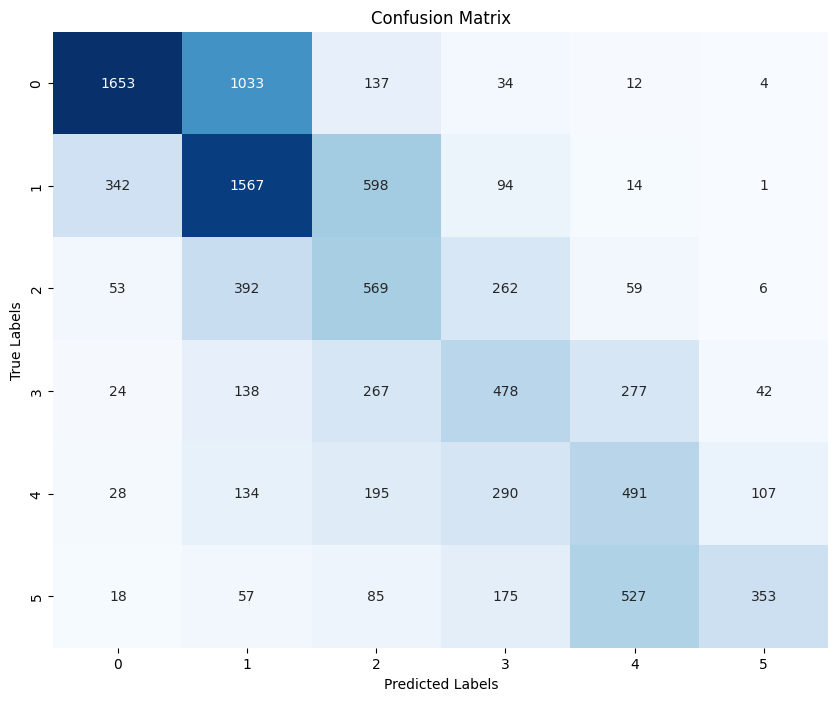

In [21]:
preds_array = np.array(all_folds_preds)
labels_array = np.array(all_folds_labels)

kappa_score = cohen_kappa_score(labels_array, preds_array, weights='quadratic')
print(f"Overall CV Score: {kappa_score:.4f}")

cm = confusion_matrix(labels_array, preds_array)

plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Plot loss curves 

{'epoch': 0, 'fold': 0, 'train_loss': 1.8280234223435283, 'tune_loss': 1.5321397727512451, 'kappa': 0.6796479786777427}
{'epoch': 1, 'fold': 0, 'train_loss': 1.308830921466534, 'tune_loss': 1.476367605737893, 'kappa': 0.6506678250505955}
{'epoch': 2, 'fold': 0, 'train_loss': 1.117322039266347, 'tune_loss': 1.4900993575532753, 'kappa': 0.6956713707482012}
{'epoch': 3, 'fold': 0, 'train_loss': 0.9864223021486027, 'tune_loss': 1.5787769936653504, 'kappa': 0.647340490406443}
{'epoch': 4, 'fold': 0, 'train_loss': 0.870765084197164, 'tune_loss': 1.2489272923354644, 'kappa': 0.7245868436827844}
{'epoch': 5, 'fold': 0, 'train_loss': 0.6555568101676369, 'tune_loss': 1.4706231754228294, 'kappa': 0.6904574473372105}
{'epoch': 6, 'fold': 0, 'train_loss': 0.5389752769880449, 'tune_loss': 1.5559374445892242, 'kappa': 0.6797484572639865}
{'epoch': 7, 'fold': 0, 'train_loss': 0.44211709933724963, 'tune_loss': 1.593912783875523, 'kappa': 0.7029486446231723}
{'epoch': 8, 'fold': 0, 'train_loss': 0.36233

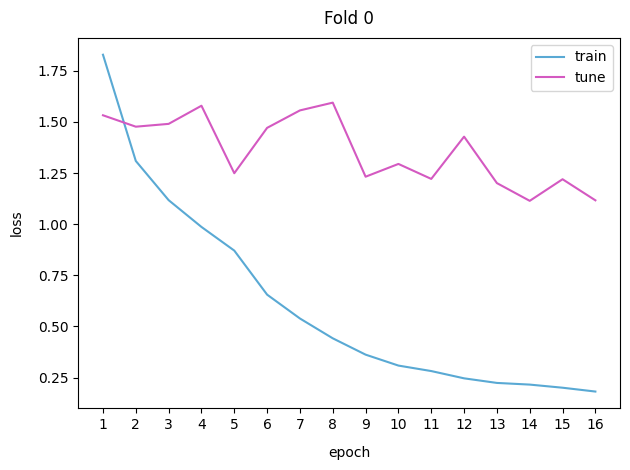

{'epoch': 0, 'fold': 1, 'train_loss': 1.911209104756112, 'tune_loss': 1.3106959964855607, 'kappa': 0.6757578921670995}
{'epoch': 1, 'fold': 1, 'train_loss': 1.3461714249390822, 'tune_loss': 1.3115617237895367, 'kappa': 0.7007794433955253}
{'epoch': 2, 'fold': 1, 'train_loss': 1.1683353328029153, 'tune_loss': 1.272335713886353, 'kappa': 0.7265186857511896}
{'epoch': 3, 'fold': 1, 'train_loss': 1.0135537002250734, 'tune_loss': 1.3236962154687169, 'kappa': 0.7369076858648923}
{'epoch': 4, 'fold': 1, 'train_loss': 0.8585760481203133, 'tune_loss': 1.6463303092014359, 'kappa': 0.709663256629478}
{'epoch': 5, 'fold': 1, 'train_loss': 0.6639058505475279, 'tune_loss': 1.2185634827039329, 'kappa': 0.740331543157645}
{'epoch': 6, 'fold': 1, 'train_loss': 0.546680224327906, 'tune_loss': 1.2759062051773071, 'kappa': 0.7237152138882641}
{'epoch': 7, 'fold': 1, 'train_loss': 0.4791822734511333, 'tune_loss': 1.1476858793252922, 'kappa': 0.779619901753329}
{'epoch': 8, 'fold': 1, 'train_loss': 0.365773

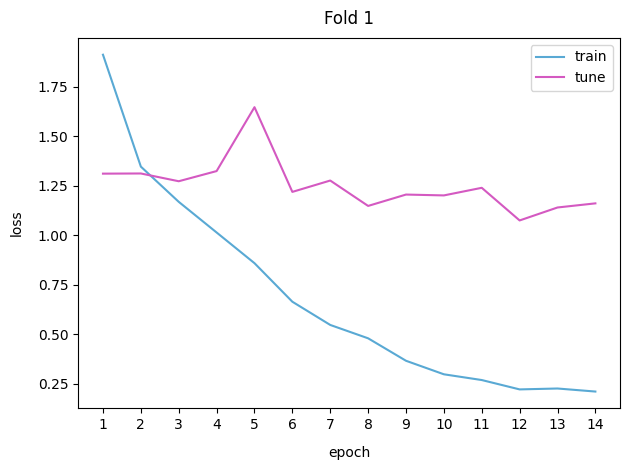

{'epoch': 0, 'fold': 2, 'train_loss': 1.8032661507486814, 'tune_loss': 1.50936764263245, 'kappa': 0.6470151097430603}
{'epoch': 1, 'fold': 2, 'train_loss': 1.3039744059566545, 'tune_loss': 1.369544342339757, 'kappa': 0.7063507505061051}
{'epoch': 2, 'fold': 2, 'train_loss': 1.100070619872707, 'tune_loss': 1.293943550931402, 'kappa': 0.6974447272285518}
{'epoch': 3, 'fold': 2, 'train_loss': 0.9598615425318359, 'tune_loss': 1.5763622400272324, 'kappa': 0.6757562698490722}
{'epoch': 4, 'fold': 2, 'train_loss': 0.7930255492447842, 'tune_loss': 1.632695622831942, 'kappa': 0.67690057722278}
{'epoch': 5, 'fold': 2, 'train_loss': 0.6080253866881977, 'tune_loss': 1.2863743456013232, 'kappa': 0.7102238148689215}
{'epoch': 6, 'fold': 2, 'train_loss': 0.4904967414946691, 'tune_loss': 1.5995843669018113, 'kappa': 0.6835262812293523}
{'epoch': 7, 'fold': 2, 'train_loss': 0.4324304857234723, 'tune_loss': 1.3951884644577301, 'kappa': 0.7223404117035489}
{'epoch': 8, 'fold': 2, 'train_loss': 0.33963987

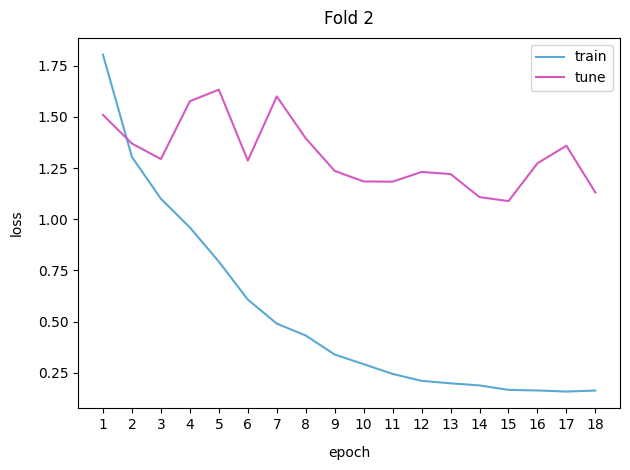

{'epoch': 0, 'fold': 3, 'train_loss': 1.7807346090131444, 'tune_loss': 1.5884154704679925, 'kappa': 0.5889710981121402}
{'epoch': 1, 'fold': 3, 'train_loss': 1.3607300592337543, 'tune_loss': 1.443731599543468, 'kappa': 0.7111133657192741}
{'epoch': 2, 'fold': 3, 'train_loss': 1.2031792084939084, 'tune_loss': 1.3027859373265003, 'kappa': 0.7489287106949358}
{'epoch': 3, 'fold': 3, 'train_loss': 1.0477755256751289, 'tune_loss': 1.368848686476788, 'kappa': 0.704565117271615}
{'epoch': 4, 'fold': 3, 'train_loss': 0.9406972580593125, 'tune_loss': 1.1809654027582652, 'kappa': 0.7357384467536887}
{'epoch': 5, 'fold': 3, 'train_loss': 0.7859046981643568, 'tune_loss': 1.187473550618413, 'kappa': 0.729087092228349}
{'epoch': 6, 'fold': 3, 'train_loss': 0.6139435261367303, 'tune_loss': 1.2477697672614132, 'kappa': 0.7186031512552613}
{'epoch': 7, 'fold': 3, 'train_loss': 0.52909880882574, 'tune_loss': 1.8853339728820755, 'kappa': 0.6022238374133762}
{'epoch': 8, 'fold': 3, 'train_loss': 0.4269269

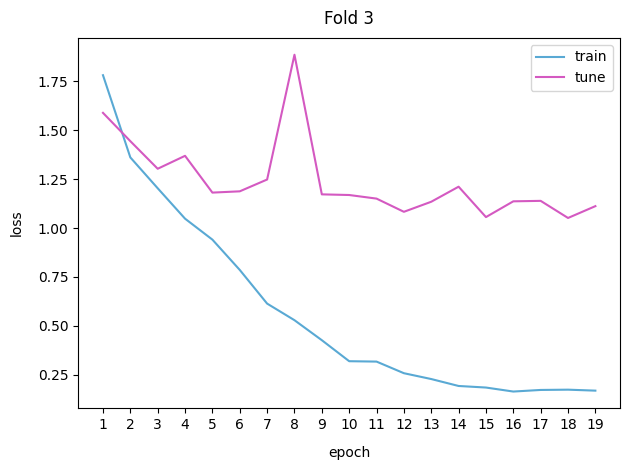

In [24]:
import matplotlib.pyplot as plt

for fold in range(nfolds):
    with open(f'/kaggle/working/logs/log_{fname}_{fold}.json') as f:
        d = json.load(f)
        epoch = []
        train_loss = []
        tune_loss = []
        kappa = []
        for sd in d:
            print(sd)
            epoch.append(sd['epoch'])
            train_loss.append(sd['train_loss'])
            tune_loss.append(sd['tune_loss'])
            kappa.append(sd['kappa'])

    

    plt.figure(dpi=100)
    plt.plot(train_loss, label='train', color="#59A9D4")
    plt.plot(tune_loss, label='tune', color="#D459C1")

    plt.title(f'Fold {fold}', pad=10)
    plt.xlabel('epoch', labelpad=10)
    plt.ylabel('loss', labelpad=10)
    plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))  # Assuming epochs start at 1
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'log_{fname}_{fold}.png')
    plt.show()